In [19]:
using Base.Iterators
using Roots
using IntervalSets
using JuMP
using Ipopt
using CompEcon
using QuantEcon
using BenchmarkTools
using LinearAlgebra
using Plots
using Combinatorics
using Interpolations

### Model settings

In [20]:
# Number of households
N = 3;

# income shocks and their transition probabilities of the household 1
inc1 = [2/3, 4/3];
P1 = hcat(repeat([0.1 0.9], 2));

# income shocks and their transition probabilities of the household 2
inc2 = [2/3, 4/3];
P2 = hcat(repeat([0.1 0.9], 2));

# income shocks and their transition probabilities of the household 2
inc3 = [2/3, 4/3];
P3 = hcat(repeat([0.1 0.9], 2));

# transition super-matrix of income shocks
R = kron(P3, P2, P1);

# number of states
# (number of income states for HH 1 times
# number of income states for HH 2)
num_states = length(inc1) * length(inc2) * length(inc3);

# Income matrix
# (col 1: HH 1's income, col 2: HH 2's income, col 3: HH 3's income)
inc_mat = vec(collect(product(inc1, inc2, inc3)));

# Aggregate income in each state
inc_ag = sum.(inc_mat);


In [21]:
util = function(c, σ::Float64);
    if σ != 1.0 
        return (c^(1.0 - σ) - 1.0) / (1.0 - σ)
    elseif σ == 1.0
        return log(c)
    end
end;

util_prime = (c, σ::Float64) -> c^(- σ);

### Value of autarky

In [22]:
δ = 0.95 # time discount factor;
σ₁ = 1.0 # coefficient of relative risk aversion of HH1;
σ₂ = 1.0 # coefficient of relative risk aversion of HH2;
σ₃ = 1.0 # coefficient of relative risk aversion of HH3;
ϕ = 0.0 # punishment under autarky;

In [23]:
inc_vec = [inc1, inc2, inc3];
P_vec = [P1, P2, P3];
σ_vec = [σ₁, σ₂, σ₃];

In [24]:
function Uaut_func(
        inc_vec, P_vec, σ_vec,
        δ, ϕ,
        util, util_prime, N
    )
    
    Uaut_vec = [zeros(length(inc_vec[i])) for i in 1:N];
    
    for i in 1:N
        Utmp_aut = zeros(length(inc_vec[i]));
        iter = 1
        diff = 1.0;
        while (diff > 1e-12) & (iter < 1000)
            Utmp_aut_new = util.(inc_vec[i] .* (1.0 - ϕ), σ_vec[i]) .+ δ .* (P_vec[i] * Utmp_aut);
            diff = maximum(abs.(Utmp_aut_new - Utmp_aut));
            Utmp_aut = Utmp_aut_new;
            iter += 1;
        end
        Uaut_vec[i] = Utmp_aut;
    end
          
#     # Matrix of expected utilities of autarky
#     Uaut = vec(collect(product(U1_aut, U2_aut)));
    return Uaut_vec
end

@time Uaut_vec = Uaut_func(inc_vec, P_vec, σ_vec, δ, ϕ, util, util_prime, N);

Uaut_prod = vec(collect(Uaut_vec[1]));
for j in 2:N
    Uaut_prod = vec(collect(product(Uaut_prod, Uaut_vec[j])))
    Uaut_prod = [reduce(vcat, [i...]) for i in Uaut_prod]
end


  1.240141 seconds (1.58 M allocations: 99.260 MiB, 15.42% gc time, 97.06% compilation time)


### Grid of relative Pareto weights and consumption on the grid points

In [25]:
# Number of grid points on relative Pareto weight (x)
num_grid_x = 50;

# Grid points of relative Pareto weights (reference: HH 1)
xmin_vec = zeros(N - 1);
xmax_vec = zeros(N - 1);

for i in 2:N
    xmin_vec[i - 1] = util_prime(maximum(inc_vec[1]), σ_vec[1]) / util_prime(minimum(inc_vec[i] * (1.0 - ϕ)), σ_vec[i]);
    xmax_vec[i - 1] = util_prime(minimum(inc_vec[1] * (1.0 - ϕ)), σ_vec[1]) / util_prime(maximum(inc_vec[i]), σ_vec[i]);
end

x_mat = zeros(N - 1, num_grid_x);
for i in 2:N
    x_mat[i - 1, :] = exp.(range(log(xmin_vec[i - 1]), log(xmax_vec[i - 1]), length = num_grid_x));
end

x_ind_prod = vec(collect(product(1:num_grid_x)))
x_ind_prod = [[i...] for i in x_ind_prod]

if N >= 3
    for j in 2:(N - 1)
        x_ind_prod = vec(collect(product(x_ind_prod, 1:num_grid_x)))
        x_ind_prod = [reduce(vcat, [i...]) for i in x_ind_prod]
    end
end

x_grid_prod = vec(collect(product(x_mat[2 - 1, :])))
x_grid_prod = [[i...] for i in x_grid_prod]

if N >= 3
    for i in 3:N
        x_grid_prod = vec(collect(product(x_grid_prod, x_mat[i - 1, :])))
        x_grid_prod = [reduce(vcat, [i...]) for i in x_grid_prod]
    end
end

x_grid_prod = reduce(hcat, x_grid_prod);


$$
    \frac{u_1'(c_{1t})}{u_i'(c_{it})} = x_{it} \quad \forall i = 2, \dots, N.
$$

In [106]:
cons_array = [[zeros(Tuple([num_grid_x for i in 1:(N - 1)])) for s in 1:num_states] for j in 1:N];

@time for s_ind in 1:num_states, x_ind in 1:length(x_ind_prod)
    x_ind_vec = x_ind_prod[x_ind];

    model = Model(Ipopt.Optimizer);
    set_silent(model)

    @variable(model, c[i = 1:N] >= 1e-6);

    for i in 1:N
        register(model, Symbol("util_", i), 1, x -> util(x, σ_vec[i]), x -> util_prime(x, σ_vec[i]); autodiff = true)
        register(model, Symbol("util_prime_", i), 1, x -> util_prime(x, σ_vec[i]); autodiff = true)
    end

    @NLobjective(model, Max, 0);
    for i in 2:N
        add_nonlinear_constraint(
            model,
            :(util_prime_1($(c[1])) / $(Symbol("util_prime_", i))($(c[i])) == $(x_mat[i - 1, x_ind_vec[i - 1]]));
        )
    end;
    @NLconstraint(model, sum(c[i] for i in 1:N) == inc_ag[s_ind]);

    optimize!(model);

    # print(value.(c), "\n")
    # @show value.(x)

    for i in 1:N
        cons_array[i][s_ind][CartesianIndex(Tuple(x_ind_vec))] = value.(c)[i];
    end
end;

123.604597 seconds (44.23 M allocations: 2.127 GiB, 11.97% gc time, 0.50% compilation time)


In [90]:
# cons_array = zeros(N, num_states, length(x_ind_prod));

# @time for s_ind in 1:num_states, x_ind in 1:length(x_ind_prod)
#     x_ind_vec = x_ind_prod[x_ind];

#     model = Model(Ipopt.Optimizer);
#     set_silent(model)

#     @variable(model, c[i = 1:N] >= 1e-6);

#     for i in 1:N
#         register(model, Symbol("util_", i), 1, x -> util(x, σ_vec[i]), x -> util_prime(x, σ_vec[i]); autodiff = true)
#         register(model, Symbol("util_prime_", i), 1, x -> util_prime(x, σ_vec[i]); autodiff = true)
#     end

#     @NLobjective(model, Max, 0);
#     for i in 2:N
#         add_nonlinear_constraint(
#             model,
#             :(util_prime_1($(c[1])) / $(Symbol("util_prime_", i))($(c[i])) == $(x_mat[i - 1, x_ind_vec[i - 1]]));
#         )
#     end;
#     @NLconstraint(model, sum(c[i] for i in 1:N) == inc_ag[s_ind]);

#     optimize!(model);

#     # print(value.(c), "\n")
#     # @show value.(x)

#     cons_array[:, s_ind, x_ind] = value.(c);
# end;

### Values under risk-sharing (full)

In [109]:
function V_full_func(
        inc_vec, P_vec, σ_vec,
        num_grid_x, R, num_states,
        inc_ag, xmin_vec, xmax_vec,
        x_mat, x_ind_prod, 
        δ, ϕ, util, util_prime,
        Uaut_vec, cons_array
    )
    
    # Value function iterations
    # Initial guess is expected utilities under autarky
    
    iter = 0;
    diff = 1.0;

    V_mat = (1.0 / (1.0 - δ)) .* cons_array;
    Vnew_mat = deepcopy(cons_array);

    while (diff > 1e-8) & (iter < 500)

        for i in 1:N, s_ind in 1:num_states
            Vnew_mat[i][s_ind] = util.(cons_array[i][s_ind], σ_vec[i]) .+ δ .* sum(R[s_ind, j] .* V_mat[i][j] for j in 1:num_states);
        end
        diff = 0.0
        for i in 1:N, s_ind in 1:num_states
            diff += maximum(abs.(V_mat[i][s_ind] - Vnew_mat[i][s_ind]))
        end        
        V_mat = deepcopy(Vnew_mat);
#         println("Difference: $diff")
        iter += 1;
    end    
    
    println("Took $iter iterations.")
    return(V_mat)
end

V_full_func (generic function with 1 method)

In [110]:
@time V_full = V_full_func(
        inc_vec, P_vec, σ_vec,
        num_grid_x, R, num_states,
        inc_ag, xmin_vec, xmax_vec,
        x_mat, x_ind_prod, 
        δ, ϕ, util, util_prime,
        Uaut_vec, cons_array
    );

Took 429 iterations.
  1.692825 seconds (897.87 k allocations: 3.683 GiB, 28.25% gc time, 17.93% compilation time)


### Values under risk-sharing (limited commitment)

Given the guessed value function, $V_i(s, x_t)$, proceed the following steps:

1. Calculate the value of $i$ without any participation constraints (i.e., the value function in the full risk-sharing where the relative Pareto weights do not change):
    $$V_i^{\text{tmp}}(s, x_t) = u_i(c(s, x_t)) + \delta E[V_i(s', x_t)|s].$$
2. Compare $V_i^{\text{tmp}}(s, x_t)$ and $U_i^{\text{aut}}(s)$ and consider the following cases:
    1. If $V_i^{\text{tmp}}(s, x_t) \ge U_i^{\text{aut}}(s)$ for all $i \in \{1, \dots, N\}$, then nobody's participation constraint is binding, so update the value function by $V_i^{\text{tmp}}(s, x_t)$ for everyone.
    2. If $V_i^{\text{tmp}}(s, x_t) < U_i^{\text{aut}}(s)$ for some $i \in \{2, \dots, N\}$, let S be the set of $i$'s with $V_i^{\text{tmp}}(s, x_t) < U_i^{\text{aut}}(s)$. Further consider the following cases:
        1. If $V_1^{\text{tmp}}(s, x_t) \ge U_1^{\text{aut}}(s)$, then derive $x$ such that $u_i(c(s, x)) + \delta E[V_i(s', x)|s] = U_i^{\text{aut}}(s)$ for $i \in S$ with $x^j = x^j_t$ for $j \notin S$;
        2. If $V_1^{\text{tmp}}(s, x_t) < U_1^{\text{aut}}(s)$ and $|S| = N - 2$, then derive $x$ such that $u_i(c(s, x)) + \delta E[V_i(s', x)|s] = U_i^{\text{aut}}(s)$ for $i \in \{1\} \cup S$;
        3. If $V_1^{\text{tmp}}(s, x_t) < U_1^{\text{aut}}(s)$ and $|S| < N - 2$, then derive $x$ such that $u_i(c(s, x)) + \delta E[V_i(s', x)|s] = U_i^{\text{aut}}(s)$ for $i \in \{1\} \cup S$ and $\frac{x^i_t}{x^i} = \frac{x^j_t}{x^j}$ for all pairs $i, j \notin S$.
    3. If $V_i^{\text{tmp}}(s, x_t) \ge U_i^{\text{aut}}(s)$ for all $i \in \{2, \dots, N\}$ and $V_1^{\text{tmp}}(s, x_t) < U_1^{\text{aut}}(s)$, then derive $x$ such that $u_1(c(s, x)) + \delta E[V_1(s', x)|s] = U_1^{\text{aut}}(s)$ and $\frac{x^i_t}{x^i} = \frac{x^j_t}{x^j}$ for all pairs $i, j \in \{2, \dots, N\}$.

In [515]:
s_ind = 1
x_ind = [20, 1]
PC_violation = zeros(Int64, N);

for i in 1:N
    PC_violation[i] = (
        util(cons_array[i][s_ind][CartesianIndex(Tuple(x_ind))], σ_vec[i]) .+ 
            δ * sum(R[s_ind, j]' * V[i][j][CartesianIndex(Tuple(x_ind))] for j in 1:num_states) < 
        Uaut_prod[s_ind][i]
        )
end

PC_violation

3-element Vector{Int64}:
 0
 0
 1

In [677]:
termination_status(model) != LOCALLY_SOLVED

false

In [ ]:
W = [sum(V_full[i][j] .- Uaut_prod[j][i] for i in 1:N) for j in 1:num_states];
W_funfit_vec = [funfitxy(basis, x_base, vec(W[s_ind]))[1] for s_ind in 1:num_states];
Wnew = deepcopy(W);

In [ ]:
W_funfit_vec = [funfitxy(basis, x_base, vec(W[s_ind]))[1] for s_ind in 1:num_states];

@time for s_ind in 1:num_states, x_ind in x_ind_prod
    
#     println("($s_ind, $x_ind)")
    
    model = Model(Ipopt.Optimizer);
    set_silent(model)
    set_optimizer_attribute(model, "max_iter", 6000)

    @variable(model, v[i = 1:N] >= 0.0);
    # @NLconstraint(model, [i = 1:N], v[i] <= 1.0)
    @variable(model, xᵣ[i = 1:(N - 1)]);
    # @NLconstraint(model, sum(v[i] for i in 1:N) == 1.0);
    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] == (1.0 + v[i + 1]) / (1.0 + v[1]) * x_mat[i, x_ind[i]])

    for i in 1:N
        register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
    end

    for s in 1:num_states
        register(
            model,
            Symbol("W_", s),
            N - 1,
            (x...) -> funeval(W_funfit_vec[s], basis, [x...])[1][1];
            autodiff = true
        )
    end

    for i in 1:N
        register(
            model, 
            Symbol("c_", i), 
            N - 1, 
            (x...) -> funeval(c_funfit_vec[i][s_ind], basis, [x...])[1][1];
            autodiff = true
        )
    end

    util_vec = [
        add_nonlinear_expression(
            model, 
            :($(Symbol("util_", i))($(Symbol("c_", i))($(xᵣ...))))
            ) for i in 1:N
        ]
    W_next_vec = [
        add_nonlinear_expression(
            model, 
            :($(R[s_ind, j]) * $(Symbol("W_", j))($(xᵣ...)))
            ) for j in 1:num_states
        ]


    @NLobjective(
        model,
        Max,
        (1.0 + v[1]) * (
            util_vec[1] - v[1] / (1.0 + v[1]) * Uaut_prod[s_ind][1] +
            sum(
                xᵣ[j - 1] * util_vec[j] - x_mat[j - 1, x_ind[j - 1]] * v[j] / (1.0 + v[1]) * Uaut_prod[s_ind][j]
                for j in 2:N
            ) + δ * sum(W_next_vec[j] for j in 1:num_states)
        )
        )


    optimize!(model)
    if termination_status(model) != LOCALLY_SOLVED
        @show termination_status(model)
    end

    Wnew[s_ind][CartesianIndex(Tuple(x_ind))] = objective_value(model);

end

diff = maximum(sum(abs.(W[s_ind] - Wnew[s_ind]) for s_ind in 1:num_states));
println("Difference: $diff")
W = deepcopy(Wnew);

iter += 1;

In [ ]:
model = Model(Ipopt.Optimizer);
set_silent(model)

@variable(model, xᵣ[i = 1:(N - 1)]);
@NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
@NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

for i in 1:N
    register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
end

for i in 1:N, s in 1:num_states
    register(
        model, 
        Symbol("V_", i, "_", s), 
        N - 1, 
        (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
        autodiff = true
    )
    register(
        model, 
        Symbol("c_", i, "_", s), 
        N - 1, 
        (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
        autodiff = true
    )

end

util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
V_next_vec = [
    [
    add_nonlinear_expression(
            model, 
            :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
            ) 
        for j in 1:num_states
    ]
    for i in 1:N
]


In [ ]:
println("Diff: $diff")

HH1_PC_violation = PC_violation[1];
HHn_PC_violation = PC_violation[2:N]; 

model = Model(Ipopt.Optimizer);
set_silent(model)

@variable(model, xᵣ[i = 1:(N - 1)]);
@NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
@NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

for i in 1:N
    register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
end

for i in 1:N, s in 1:num_states
    register(
        model, 
        Symbol("V_", i, "_", s), 
        N - 1, 
        (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
        autodiff = true
    )
    register(
        model, 
        Symbol("c_", i, "_", s), 
        N - 1, 
        (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
        autodiff = true
    )

end

util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
V_next_vec = [
    [
    add_nonlinear_expression(
            model, 
            :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
            ) 
        for j in 1:num_states
    ]
    for i in 1:N
]

# |S| constraints
for i in 1:N
    @NLconstraint(
        model, 
        util_vec[i] + δ * sum(V_next_vec[i][j] for j in 1:num_states) >= Uaut_prod[s_ind][i]
    )
end

@NLobjective(model, Min, 0);

@time optimize!(model)




In [516]:
PC_violation_new = zeros(Int64, N);

diff = 1
while (diff > 0.0)
    
    println("Diff: $diff")

    HH1_PC_violation = PC_violation[1];
    HHn_PC_violation = PC_violation[2:N]; 

    model = Model(Ipopt.Optimizer);
    set_silent(model)

    @variable(model, xᵣ[i = 1:(N - 1)]);
    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

    for i in 1:N
        register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
    end

    for i in 1:N, s in 1:num_states
        register(
            model, 
            Symbol("V_", i, "_", s), 
            N - 1, 
            (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
            autodiff = true
        )
        register(
            model, 
            Symbol("c_", i, "_", s), 
            N - 1, 
            (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
            autodiff = true
        )

    end

    util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
    V_next_vec = [
        [
        add_nonlinear_expression(
                model, 
                :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                ) 
            for j in 1:num_states
        ]
        for i in 1:N
    ]

    # |S| constraints
    for i in findall(HHn_PC_violation .== 1)
        @NLconstraint(
            model, 
            util_vec[i + 1] + δ * sum(V_next_vec[i + 1][j] for j in 1:num_states) == Uaut_prod[s_ind][i + 1]
        )
    end

    # (N - 1) - |S| constraints
    for k in findall(HHn_PC_violation .== 0);
        @NLconstraint(model, x_mat[k, x_ind[k]] == xᵣ[k])
    end

    @NLobjective(model, Min, 0);

    @time optimize!(model)


    for i in 1:N
        PC_violation_new[i] = (
            util(funeval(c_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1], σ_vec[i]) .+ 
                δ * sum(R[s_ind, j]' * funeval(V_funfit_vec[i][j], basis, value.(xᵣ))[1][1] for j in 1:num_states) < 
            Uaut_prod[s_ind][i]
            )
    end

    @show PC_violation
    @show PC_violation_new
    @show diff = sum(abs.(PC_violation .- (PC_violation .| PC_violation_new)));
    
    PC_violation = (PC_violation .| PC_violation_new);

end



Diff: 1.0
  9.602035 seconds (9.16 M allocations: 519.078 MiB, 12.91% gc time, 96.28% compilation time)
PC_violation = [0, 0, 1]
PC_violation_new = [0, 1, 0]
diff = sum(abs.(PC_violation .- (PC_violation .| PC_violation_new))) = 1
Diff: 1
  0.198124 seconds (122.60 k allocations: 11.189 MiB)
PC_violation = [0, 1, 1]
PC_violation_new = [0, 0, 0]
diff = sum(abs.(PC_violation .- (PC_violation .| PC_violation_new))) = 0


In [517]:
@show value.(xᵣ)
for i in 1:N
    @show util(funeval(c_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1], σ_vec[i]) .+ δ * sum(R[s_ind, j]' * funeval(V_funfit_vec[i][j], basis, value.(xᵣ))[1][1] for j in 1:num_states)
end

value.(xᵣ) = [1.2075517306214105, 1.2075517306211425]
util(((funeval((c_funfit_vec[i])[s_ind], basis, value.(xᵣ)))[1])[1], σ_vec[i]) .+ δ * sum(((R[s_ind, j])' * ((funeval((V_funfit_vec[i])[j], basis, value.(xᵣ)))[1])[1] for j = 1:num_states)) = 4.496099112672783
util(((funeval((c_funfit_vec[i])[s_ind], basis, value.(xᵣ)))[1])[1], σ_vec[i]) .+ δ * sum(((R[s_ind, j])' * ((funeval((V_funfit_vec[i])[j], basis, value.(xᵣ)))[1])[1] for j = 1:num_states)) = 3.7435240861766754
util(((funeval((c_funfit_vec[i])[s_ind], basis, value.(xᵣ)))[1])[1], σ_vec[i]) .+ δ * sum(((R[s_ind, j])' * ((funeval((V_funfit_vec[i])[j], basis, value.(xᵣ)))[1])[1] for j = 1:num_states)) = 3.743524086171924


In [509]:
@show value.(xᵣ)
@show util(funeval(c_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1], σ_vec[i]) .+ δ * sum(R[s_ind, j]' * funeval(V_funfit_vec[i][j], basis, value.(xᵣ))[1][1] for j in 1:num_states)

value.(xᵣ) = [1.384521785922135, 1.2978373455648]
util(((funeval((c_funfit_vec[i])[s_ind], basis, value.(xᵣ)))[1])[1], σ_vec[i]) .+ δ * sum(((R[s_ind, j])' * ((funeval((V_funfit_vec[i])[j], basis, value.(xᵣ)))[1])[1] for j = 1:num_states)) = 3.7434393520405562


3.7434393520405562

In [474]:
solution_summary(model)

* Solver : Ipopt

* Status
  Termination status : LOCALLY_SOLVED
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution
  Objective value      : 0.00000e+00

* Work counters
  Solve time (sec)   : 1.91402e+01


In [475]:
PC_violation_new = zeros(Int64, N);

for i in 1:N
    PC_violation_new[i] = (
        util(funeval(c_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1], σ_vec[i]) .+ 
            δ * sum(R[s_ind, j]' * funeval(V_funfit_vec[i][j], basis, value.(xᵣ))[1][1] for j in 1:num_states) < 
        Uaut_prod[s_ind][i]
        )
end

if all(PC_violation .== PC_violation .| PC_violation_new)
    break
end


HH1_PC_violation_new = PC_violation_new[1];
HHn_PC_violation_new = @view PC_violation_new[2:N]; 


In [454]:
i = 3
s_ind = 1
util(funeval(c_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1], σ_vec[i]) .+ δ * sum(R[s_ind, j]' * funeval(V_funfit_vec[i][j], basis, value.(xᵣ))[1][1] for j in 1:num_states)

3.7435146480406885

In [456]:
Uaut_prod[1][1] ≈ util(funeval(c_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1], σ_vec[i]) .+ δ * sum(R[s_ind, j]' * funeval(V_funfit_vec[i][j], basis, value.(xᵣ))[1][1] for j in 1:num_states)

true

In [476]:
PC_violation

3-element Vector{Int64}:
 0
 1
 1

In [477]:
PC_violation_new

3-element Vector{Int64}:
 0
 0
 0

In [481]:
!all(PC_violation .== PC_violation .| PC_violation_new)

false

In [471]:
PC_violation_update = PC_violation .| PC_violation_new

3-element Vector{Int64}:
 0
 1
 1

In [ ]:
basis = fundefn(:spli, [num_grid_x for i in 1:(N - 1)], xmin_vec, xmax_vec);
x_base = funnode(basis)[1];
c_funfit_vec = [[funfitxy(basis, x_base, vec(cons_array[i][s_ind]))[1] for s_ind in 1:num_states] for i in 1:N];

V_funfit_vec = [[funfitxy(basis, x_base, vec(V[i][s_ind]))[1] for s_ind in 1:num_states] for i in 1:N];
        

PC_violation = zeros(Int64, N);

for i in 1:N
    PC_violation[i] = (
        util(cons_array[i][s_ind][CartesianIndex(Tuple(x_ind))], σ_vec[i]) .+ 
            δ * sum(R[s_ind, j]' * V[i][j][CartesianIndex(Tuple(x_ind))] for j in 1:num_states) < 
        Uaut_prod[s_ind][i]
        )
end

HH1_PC_violation = PC_violation[1];
HHn_PC_violation = @view PC_violation[2:N]; 

function calculate_x(
    PC_violation_union
    )

end

# Cases B.a ==================================================================
if any(HHn_PC_violation .== 1) & (HH1_PC_violation == 0)

    model = Model(Ipopt.Optimizer);
    set_silent(model)

    @variable(model, xᵣ[i = 1:(N - 1)]);
    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

    for i in 1:N
        register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
    end

    for i in 1:N, s in 1:num_states
        register(
            model, 
            Symbol("V_", i, "_", s), 
            N - 1, 
            (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
            autodiff = true
        )
        register(
            model, 
            Symbol("c_", i, "_", s), 
            N - 1, 
            (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
            autodiff = true
        )

    end

    util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
    V_next_vec = [
        [
        add_nonlinear_expression(
                model, 
                :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                ) 
            for j in 1:num_states
        ]
        for i in 1:N
    ]

    # |S| constraints
    for i in findall(HHn_PC_violation .== 1)
        @NLconstraint(
            model, 
            util_vec[i + 1] + δ * sum(V_next_vec[i + 1][j] for j in 1:num_states) == Uaut_prod[s_ind][i + 1]
        )
    end

#             # (N - 1) - |S| constraints
#             for k in findall(HHn_PC_violation .== 0);
#                 @NLconstraint(model, x_mat[k, x_ind[k]] == xᵣ[k])
#             end

    # (N - 1) - |S| constraints
    @NLconstraint(
        model, 
        util_vec[i] + δ * sum(V_next_vec[1][j] for j in 1:num_states) >= Uaut_prod[s_ind][1]
    )

    for k in findall(HHn_PC_violation .== 0);
        @NLconstraint(
            model, 
            (x_mat[k, x_ind[k]] - xᵣ[k]) * (
                (
                    util_vec[1] + δ * sum(V_next_vec[1][j] for j in 1:num_states) - Uaut_prod[s_ind][1]
                    ) *
                (
                    util_vec[k + 1] + δ * sum(V_next_vec[k + 1][j] for j in 1:num_states) - Uaut_prod[s_ind][k + 1]
                    )
                ) == 0
        )    
        @NLconstraint(
            model, 
            util_vec[k + 1] + δ * sum(V_next_vec[k + 1][j] for j in 1:num_states) >= Uaut_prod[s_ind][k + 1]
        )
    end

    @NLobjective(model, Min, 0);

    optimize!(model)
    @show termination_status(model)
    for i in 1:N
        Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1]
    end


# Cases B.b and B.c ==================================================================
elseif any(HHn_PC_violation .== 1) & (HH1_PC_violation == 1)
    # Case B.c
    if sum(HHn_PC_violation .== 1) == N - 2

        model = Model(Ipopt.Optimizer);
        set_silent(model)

        @variable(model, xᵣ[i = 1:(N - 1)]);
        @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
        @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

        for i in 1:N
            register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
        end

        for i in 1:N, s in 1:num_states
            register(
                model, 
                Symbol("V_", i, "_", s), 
                N - 1, 
                (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
                autodiff = true
            )
            register(
                model, 
                Symbol("c_", i, "_", s), 
                N - 1, 
                (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
                autodiff = true
            )

        end

        util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
        V_next_vec = [
            [
            add_nonlinear_expression(
                    model, 
                    :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                    ) 
                for j in 1:num_states
            ]
            for i in 1:N
        ]

        # 1 constraint
        @NLconstraint(
            model, 
            util_vec[1] + δ * sum(V_next_vec[1][j] for j in 1:num_states) == Uaut_prod[s_ind][1]
        )

        # (N - 2) constraints
        for i in findall(HHn_PC_violation .== 1)
            @NLconstraint(
                model, 
                util_vec[i + 1] + δ * sum(V_next_vec[i + 1][j] for j in 1:num_states) == Uaut_prod[s_ind][i + 1]
            )
        end

        @NLobjective(model, Min, 0);

        optimize!(model)
        @show termination_status(model)

        for i in 1:N
            Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1]
        end

    # Case B.b 
    elseif sum(HHn_PC_violation .== 1) < N - 2

        model = Model(Ipopt.Optimizer);
        set_silent(model)

        @variable(model, xᵣ[i = 1:(N - 1)]);
        @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
        @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

        for i in 1:N
            register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
        end

        for i in 1:N, s in 1:num_states
            register(
                model, 
                Symbol("V_", i, "_", s), 
                N - 1, 
                (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
                autodiff = true
            )
            register(
                model, 
                Symbol("c_", i, "_", s), 
                N - 1, 
                (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
                autodiff = true
            )

        end

        util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
        V_next_vec = [
            [
            add_nonlinear_expression(
                    model, 
                    :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                    ) 
                for j in 1:num_states
            ]
            for i in 1:N
        ]

        # 1 constraint
        @NLconstraint(
            model, 
            util_vec[1] + δ * sum(V_next_vec[1][j] for j in 1:num_states) == Uaut_prod[s_ind][1]
        )

        # |S| constraints
        for i in findall(HHn_PC_violation .== 1)
            @NLconstraint(
                model, 
                util_vec[i + 1] + δ * sum(V_next_vec[i + 1][j] for j in 1:num_states) == Uaut_prod[s_ind][i + 1]
            )
        end

        # ((N - 1) - |S|) - 1 constraints
        nonbinding_x_ratio = [
            add_nonlinear_expression(model, xᵣ[k] / x_mat[k, x_ind[k]]) 
                for k in findall(HHn_PC_violation .== 0)
            ];
        for k in 2:length(nonbinding_x_ratio)
            @NLconstraint(
                model,
                nonbinding_x_ratio[1] == nonbinding_x_ratio[k]
            )
        end

        @NLobjective(model, Min, 0);

        optimize!(model)
        @show termination_status(model)

        for i in 1:N
            Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1]
        end
    end
# Case C ==================================================================
elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 1)

    model = Model(Ipopt.Optimizer);
    set_silent(model)

    @variable(model, xᵣ[i = 1:(N - 1)]);
    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
    @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

    for i in 1:N
        register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
    end

    for i in 1:N, s in 1:num_states
        register(
            model, 
            Symbol("V_", i, "_", s), 
            N - 1, 
            (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
            autodiff = true
        )
        register(
            model, 
            Symbol("c_", i, "_", s), 
            N - 1, 
            (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
            autodiff = true
        )

    end

    util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
    V_next_vec = [
        [
        add_nonlinear_expression(
                model, 
                :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                ) 
            for j in 1:num_states
        ]
        for i in 1:N
    ]

    # 1 constraint
    @NLconstraint(
        model, 
        util_vec[1] + δ * sum(V_next_vec[1][j] for j in 1:num_states) == Uaut_prod[s_ind][1]
    )

    # (N - 1) - 1 constraints
    if N >= 3
        nonbinding_x_ratio = [
            add_nonlinear_expression(model, xᵣ[k] / x_mat[k, x_ind[k]]) 
                for k in findall(HHn_PC_violation .== 0)
            ];
        for k in 2:length(nonbinding_x_ratio)
            @NLconstraint(
                model,
                nonbinding_x_ratio[1] == nonbinding_x_ratio[k]
            )
        end
    end

    @NLobjective(model, Min, 0);

    optimize!(model)
    @show termination_status(model)

    for i in 1:N
        Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1]
    end    

# Case A ==================================================================
elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 0)
    for i in 1:N
        Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, [x_mat[k, x_ind[k]] for k in 1:(N - 1)])[1][1]
    end 
end



In [411]:
basis = fundefn(:spli, [num_grid_x for i in 1:(N - 1)], xmin_vec, xmax_vec);
x_base = funnode(basis)[1];
c_funfit_vec = [[funfitxy(basis, x_base, vec(cons_array[i][s_ind]))[1] for s_ind in 1:num_states] for i in 1:N];

V_funfit_vec = [[funfitxy(basis, x_base, vec(V[i][s_ind]))[1] for s_ind in 1:num_states] for i in 1:N];
        

function func_tmp!(Vnew, V)
    
#     for s_ind in 1:num_states, x_ind in x_ind_prod[1:100]
    for s_ind in 1:2, x_ind in x_ind_prod[1:50]
            
        println("($s_ind, $x_ind)")

        PC_violation = zeros(Int64, N);

        for i in 1:N
            PC_violation[i] = (
                util(cons_array[i][s_ind][CartesianIndex(Tuple(x_ind))], σ_vec[i]) .+ 
                    δ * sum(R[s_ind, j]' * V[i][j][CartesianIndex(Tuple(x_ind))] for j in 1:num_states) < 
                Uaut_prod[s_ind][i]
                )
        end

        HH1_PC_violation = PC_violation[1];
        HHn_PC_violation = @view PC_violation[2:N]; 

        # Cases B.a ==================================================================
        if any(HHn_PC_violation .== 1) & (HH1_PC_violation == 0)

            model = Model(Ipopt.Optimizer);
            set_silent(model)

            @variable(model, xᵣ[i = 1:(N - 1)]);
            @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
            @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

            for i in 1:N
                register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
            end

            for i in 1:N, s in 1:num_states
                register(
                    model, 
                    Symbol("V_", i, "_", s), 
                    N - 1, 
                    (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
                    autodiff = true
                )
                register(
                    model, 
                    Symbol("c_", i, "_", s), 
                    N - 1, 
                    (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
                    autodiff = true
                )

            end

            util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
            V_next_vec = [
                [
                add_nonlinear_expression(
                        model, 
                        :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                        ) 
                    for j in 1:num_states
                ]
                for i in 1:N
            ]

            # |S| constraints
            for i in findall(HHn_PC_violation .== 1)
                @NLconstraint(
                    model, 
                    util_vec[i + 1] + δ * sum(V_next_vec[i + 1][j] for j in 1:num_states) == Uaut_prod[s_ind][i + 1]
                )
            end

#             # (N - 1) - |S| constraints
#             for k in findall(HHn_PC_violation .== 0);
#                 @NLconstraint(model, x_mat[k, x_ind[k]] == xᵣ[k])
#             end

            # (N - 1) - |S| constraints
            @NLconstraint(
                model, 
                util_vec[i] + δ * sum(V_next_vec[1][j] for j in 1:num_states) >= Uaut_prod[s_ind][1]
            )

            for k in findall(HHn_PC_violation .== 0);
                @NLconstraint(
                    model, 
                    (x_mat[k, x_ind[k]] - xᵣ[k]) * (
                        (
                            util_vec[1] + δ * sum(V_next_vec[1][j] for j in 1:num_states) - Uaut_prod[s_ind][1]
                            ) *
                        (
                            util_vec[k + 1] + δ * sum(V_next_vec[k + 1][j] for j in 1:num_states) - Uaut_prod[s_ind][k + 1]
                            )
                        ) == 0
                )    
                @NLconstraint(
                    model, 
                    util_vec[k + 1] + δ * sum(V_next_vec[k + 1][j] for j in 1:num_states) >= Uaut_prod[s_ind][k + 1]
                )
            end

            @NLobjective(model, Min, 0);

            optimize!(model)
            @show termination_status(model)
            for i in 1:N
                Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1]
            end


        # Cases B.b and B.c ==================================================================
        elseif any(HHn_PC_violation .== 1) & (HH1_PC_violation == 1)
            # Case B.c
            if sum(HHn_PC_violation .== 1) == N - 2

                model = Model(Ipopt.Optimizer);
                set_silent(model)

                @variable(model, xᵣ[i = 1:(N - 1)]);
                @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
                @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

                for i in 1:N
                    register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
                end

                for i in 1:N, s in 1:num_states
                    register(
                        model, 
                        Symbol("V_", i, "_", s), 
                        N - 1, 
                        (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
                        autodiff = true
                    )
                    register(
                        model, 
                        Symbol("c_", i, "_", s), 
                        N - 1, 
                        (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
                        autodiff = true
                    )

                end

                util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
                V_next_vec = [
                    [
                    add_nonlinear_expression(
                            model, 
                            :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                            ) 
                        for j in 1:num_states
                    ]
                    for i in 1:N
                ]

                # 1 constraint
                @NLconstraint(
                    model, 
                    util_vec[1] + δ * sum(V_next_vec[1][j] for j in 1:num_states) == Uaut_prod[s_ind][1]
                )

                # (N - 2) constraints
                for i in findall(HHn_PC_violation .== 1)
                    @NLconstraint(
                        model, 
                        util_vec[i + 1] + δ * sum(V_next_vec[i + 1][j] for j in 1:num_states) == Uaut_prod[s_ind][i + 1]
                    )
                end

                @NLobjective(model, Min, 0);

                optimize!(model)
                @show termination_status(model)

                for i in 1:N
                    Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1]
                end

            # Case B.b 
            elseif sum(HHn_PC_violation .== 1) < N - 2

                model = Model(Ipopt.Optimizer);
                set_silent(model)

                @variable(model, xᵣ[i = 1:(N - 1)]);
                @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
                @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

                for i in 1:N
                    register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
                end

                for i in 1:N, s in 1:num_states
                    register(
                        model, 
                        Symbol("V_", i, "_", s), 
                        N - 1, 
                        (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
                        autodiff = true
                    )
                    register(
                        model, 
                        Symbol("c_", i, "_", s), 
                        N - 1, 
                        (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
                        autodiff = true
                    )

                end

                util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
                V_next_vec = [
                    [
                    add_nonlinear_expression(
                            model, 
                            :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                            ) 
                        for j in 1:num_states
                    ]
                    for i in 1:N
                ]

                # 1 constraint
                @NLconstraint(
                    model, 
                    util_vec[1] + δ * sum(V_next_vec[1][j] for j in 1:num_states) == Uaut_prod[s_ind][1]
                )

                # |S| constraints
                for i in findall(HHn_PC_violation .== 1)
                    @NLconstraint(
                        model, 
                        util_vec[i + 1] + δ * sum(V_next_vec[i + 1][j] for j in 1:num_states) == Uaut_prod[s_ind][i + 1]
                    )
                end

                # ((N - 1) - |S|) - 1 constraints
                nonbinding_x_ratio = [
                    add_nonlinear_expression(model, xᵣ[k] / x_mat[k, x_ind[k]]) 
                        for k in findall(HHn_PC_violation .== 0)
                    ];
                for k in 2:length(nonbinding_x_ratio)
                    @NLconstraint(
                        model,
                        nonbinding_x_ratio[1] == nonbinding_x_ratio[k]
                    )
                end

                @NLobjective(model, Min, 0);

                optimize!(model)
                @show termination_status(model)

                for i in 1:N
                    Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1]
                end
            end
        # Case C ==================================================================
        elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 1)

            model = Model(Ipopt.Optimizer);
            set_silent(model)

            @variable(model, xᵣ[i = 1:(N - 1)]);
            @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] >= xmin_vec[i])
            @NLconstraint(model, [i = 1:(N - 1)], xᵣ[i] <= xmax_vec[i])

            for i in 1:N
                register(model, Symbol("util_", i), 1, x -> util(max(x, 1e-8), σ_vec[i]); autodiff = true)
            end

            for i in 1:N, s in 1:num_states
                register(
                    model, 
                    Symbol("V_", i, "_", s), 
                    N - 1, 
                    (x...) -> funeval(V_funfit_vec[i][s], basis, [x...])[1][1];
                    autodiff = true
                )
                register(
                    model, 
                    Symbol("c_", i, "_", s), 
                    N - 1, 
                    (x...) -> funeval(c_funfit_vec[i][s], basis, [x...])[1][1];
                    autodiff = true
                )

            end

            util_vec = [add_nonlinear_expression(model, :($(Symbol("util_", i))($(Symbol("c_", i, "_", s_ind))($(xᵣ...))))) for i in 1:N]
            V_next_vec = [
                [
                add_nonlinear_expression(
                        model, 
                        :($(R[s_ind, j]) * $(Symbol("V_", i, "_", j))($(xᵣ...)))
                        ) 
                    for j in 1:num_states
                ]
                for i in 1:N
            ]

            # 1 constraint
            @NLconstraint(
                model, 
                util_vec[1] + δ * sum(V_next_vec[1][j] for j in 1:num_states) == Uaut_prod[s_ind][1]
            )

            # (N - 1) - 1 constraints
            if N >= 3
                nonbinding_x_ratio = [
                    add_nonlinear_expression(model, xᵣ[k] / x_mat[k, x_ind[k]]) 
                        for k in findall(HHn_PC_violation .== 0)
                    ];
                for k in 2:length(nonbinding_x_ratio)
                    @NLconstraint(
                        model,
                        nonbinding_x_ratio[1] == nonbinding_x_ratio[k]
                    )
                end
            end

            @NLobjective(model, Min, 0);

            optimize!(model)
            @show termination_status(model)

            for i in 1:N
                Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, value.(xᵣ))[1][1]
            end    

        # Case A ==================================================================
        elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 0)
            for i in 1:N
                Vnew[i][s_ind][CartesianIndex(Tuple(x_ind))] = funeval(V_funfit_vec[i][s_ind], basis, [x_mat[k, x_ind[k]] for k in 1:(N - 1)])[1][1]
            end 
        end

    end
end

func_tmp! (generic function with 1 method)

In [412]:
Vnew = deepcopy(V);
@time func_tmp!(Vnew, V)

(1, [1, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [2, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [3, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [4, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [5, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [6, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [7, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [8, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [9, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [10, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [11, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [12, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [13, 1])
termination_status(model) = MathOptInterface.LOCALLY_SOLVED
(1, [14, 1])
termination_status(model) = MathOptInterface.LO

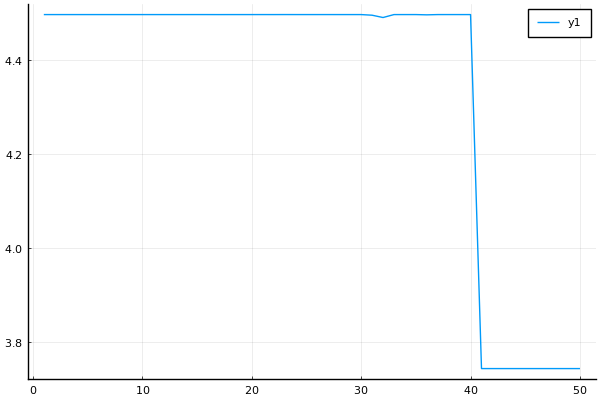

In [513]:
plot(1:50, Vnew[1][1][1:50, 1])

In [ ]:

# for x_ind in 1:length(x_ind_prod)
function func_tmp!(V_new, V)

    PC_violation = zeros(Int64, N)

    for s_ind in 1:num_states, x_ind in x_ind_prod

        for i in 1:N
            PC_violation[i] = util(cons_array[i][s_ind][CartesianIndex(Tuple(x_ind))], σ_vec[i]) .+ 
                δ * sum(R[s_ind, j]' * V[i][j][CartesianIndex(Tuple(x_ind))] for j in 1:num_states) < Uaut_prod[s_ind][i]
        end

        HH1_PC_violation = PC_violation[1];
        HHn_PC_violation = @view PC_violation[2:N]; 

        # Cases B.a
        if any(HHn_PC_violation .== 1) & (HH1_PC_violation == 0)
            
            abs_dev = zeros(length(x_ind_prod));
            # |S| constraints
            for i in findall(HHn_PC_violation .== 1)
                abs_dev += abs.(
                    util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
                    Uaut_prod[s_ind][i + 1]
                ) ./ Uaut_prod[s_ind][i + 1]
            end

            # (N - 1) - |S| constraints
            xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];
            for k in findall(HHn_PC_violation .== 0);
                abs_dev += abs.(xₛ[k] .- x_grid_prod[k, :]) ./ xₛ[k];
            end

            x_ind_new = findmin(abs_dev)[2];

            for i in 1:N
                V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
            end
            
        # Cases B.b and B.c
        elseif any(HHn_PC_violation .== 1) & (HH1_PC_violation == 1)
            # Case B.c
            if sum(HHn_PC_violation .== 1) == N - 2
                abs_dev = zeros(length(x_ind_prod));

                # 1 constraint
                abs_dev += abs.(
                    util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
                    Uaut_prod[s_ind][1]
                ) ./ Uaut_prod[s_ind][1]

                # N - 2 constraints
                for i in findall(HHn_PC_violation .== 1)
                    abs_dev_value_aut = abs.(
                        util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
                        Uaut_prod[s_ind][i + 1]
                    ) ./ Uaut_prod[s_ind][i + 1]
                    abs_dev += abs_dev_value_aut .+ ((abs_dev_value_aut .< 0) .* 1e+5)
                end

                x_ind_new = findmin(abs_dev)[2];

                for i in 1:N
                    V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
                end 
            # Case B.b
            elseif sum(HHn_PC_violation .== 1) < N - 2
                abs_dev = zeros(length(x_ind_prod));

                # 1 constraint
                abs_dev += abs.(
                    util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
                    Uaut_prod[s_ind][1]
                ) ./ Uaut_prod[s_ind][1]

                # |S| constraints
                for i in findall(HHn_PC_violation .== 1)
                    abs_dev += abs.(
                        util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
                        Uaut_prod[s_ind][i + 1]
                    ) ./ Uaut_prod[s_ind][i + 1]
                end

                # ((N - 1) - |S|) - 1 constraints
                xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];

                x_ratio_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0));
                for k in findall(HHn_PC_violation .== 0);
                    x_ratio_mat[:, k] = xₛ[k] ./ x_grid_prod[k, :];
                end

                x_ratio_diff_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0) - 1);
                for k in 2:sum(HHn_PC_violation .== 0)
                    x_ratio_diff_mat[:, k - 1] = abs.(x_ratio_mat[:, k] .- x_ratio_mat[:, 1]) ./  x_ratio_mat[:, 1];
                end

                abs_dev += vec(sum(x_ratio_diff_mat, dims = 2));

                x_ind_new = findmin(abs_dev)[2]

                for i in 1:N
                    V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
                end 
            end
        # Case C
        elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 1)

            abs_dev = zeros(length(x_ind_prod));

            # 1 constraint
            abs_dev += abs.(
                util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
                Uaut_prod[s_ind][1]
            ) ./ Uaut_prod[s_ind][1]

            # (N - 1) - 1 constraints
            if N >= 3        
                xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];

                x_ratio_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0));
                for k in findall(HHn_PC_violation .== 0);
                    x_ratio_mat[:, k] = xₛ[k] ./ x_grid_prod[k, :];
                end

                x_ratio_diff_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0) - 1);
                for k in 2:sum(HHn_PC_violation .== 0)
                    x_ratio_diff_mat[:, k - 1] = abs.(x_ratio_mat[:, k] .- x_ratio_mat[:, 1]) ./ x_ratio_mat[:, 1];
                end
                abs_dev += vec(sum(x_ratio_diff_mat, dims = 2));
            end

            x_ind_new = findmin(abs_dev)[2]

            for i in 1:N
                V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
            end 
        # Case A
        elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 0)
            for i in 1:N
                V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind], σ_vec[i]) .+ δ * V[i, :, x_ind]' * R[s_ind, :]
            end 
        end
    end
    
end


In [294]:
objective_value(model)

0.0

In [295]:
value.(xᵣ)

2-element Vector{Float64}:
 0.43077489349604925
 0.43077489349607373

In [36]:

# # for x_ind in 1:length(x_ind_prod)
# function func_tmp!(V_new, V)

#     PC_violation = zeros(Int64, N)

#     for s_ind in 1:num_states, x_ind in 1:length(x_ind_prod)

#         for i in 1:N
#             PC_violation[i] = util(cons_array[i, s_ind, x_ind], σ_vec[i]) .+ δ * R[s_ind, :]' * V[i, :, x_ind] < Uaut_prod[s_ind][i]
#         end

#         HH1_PC_violation = PC_violation[1];
#         HHn_PC_violation = @view PC_violation[2:N]; 

#         # Cases B.a
#         if any(HHn_PC_violation .== 1) & (HH1_PC_violation == 0)
            
#             abs_dev = zeros(length(x_ind_prod));
#             # |S| constraints
#             for i in findall(HHn_PC_violation .== 1)
#                 abs_dev_value_aut = abs.(
#                     util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
#                     Uaut_prod[s_ind][i + 1]
#                 ) ./ Uaut_prod[s_ind][i + 1]
#                 abs_dev += abs_dev_value_aut .+ ((abs_dev_value_aut .< 0) .* 1e+5)
#             end

#             # (N - 1) - |S| constraints
#             xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];
#             for k in findall(HHn_PC_violation .== 0);
#                 abs_dev += abs.(xₛ[k] .- x_grid_prod[k, :]) ./ xₛ[k];
#             end

#             x_ind_new = findmin(abs_dev)[2];

#             for i in 1:N
#                 V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
#             end
            
#         # Cases B.b and B.c
#         elseif any(HHn_PC_violation .== 1) & (HH1_PC_violation == 1)
#             # Case B.c
#             if sum(HHn_PC_violation .== 1) == N - 2
#                 abs_dev = zeros(length(x_ind_prod));

#                 # 1 constraint
#                 abs_dev_value_aut = abs.(
#                     util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
#                     Uaut_prod[s_ind][1]
#                 ) ./ Uaut_prod[s_ind][1]
#                 abs_dev += abs_dev_value_aut .+ ((abs_dev_value_aut .< 0) .* 1e+5)

#                 # N - 2 constraints
#                 for i in findall(HHn_PC_violation .== 1)
#                     abs_dev_value_aut = abs.(
#                         util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
#                         Uaut_prod[s_ind][i + 1]
#                     ) ./ Uaut_prod[s_ind][i + 1]
#                     abs_dev += abs_dev_value_aut .+ ((abs_dev_value_aut .< 0) .* 1e+5)
#                 end

#                 x_ind_new = findmin(abs_dev)[2];

#                 for i in 1:N
#                     V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
#                 end 
#             # Case B.b
#             elseif sum(HHn_PC_violation .== 1) < N - 2
#                 abs_dev = zeros(length(x_ind_prod));

#                 # 1 constraint
#                 abs_dev_value_aut = abs.(
#                     util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
#                     Uaut_prod[s_ind][1]
#                 ) ./ Uaut_prod[s_ind][1]
#                 abs_dev += abs_dev_value_aut .+ ((abs_dev_value_aut .< 0) .* 1e+5)

#                 # |S| constraints
#                 for i in findall(HHn_PC_violation .== 1)
#                     abs_dev_value_aut = abs.(
#                         util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
#                         Uaut_prod[s_ind][i + 1]
#                     ) ./ Uaut_prod[s_ind][i + 1]
#                     abs_dev += abs_dev_value_aut .+ ((abs_dev_value_aut .< 0) .* 1e+5)
#                 end

#                 # ((N - 1) - |S|) - 1 constraints
#                 xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];

#                 x_ratio_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0));
#                 for k in findall(HHn_PC_violation .== 0);
#                     x_ratio_mat[:, k] = xₛ[k] ./ x_grid_prod[k, :];
#                 end

#                 x_ratio_diff_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0) - 1);
#                 for k in 2:sum(HHn_PC_violation .== 0)
#                     x_ratio_diff_mat[:, k - 1] = abs.(x_ratio_mat[:, k] .- x_ratio_mat[:, 1]) ./  x_ratio_mat[:, 1];
#                 end

#                 abs_dev += vec(sum(x_ratio_diff_mat, dims = 2));

#                 x_ind_new = findmin(abs_dev)[2]

#                 for i in 1:N
#                     V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
#                 end 
#             end
#         # Case C
#         elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 1)

#             abs_dev = zeros(length(x_ind_prod));

#             # 1 constraint
#             abs_dev_value_aut = abs.(
#                 util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
#                 Uaut_prod[s_ind][1]
#             ) ./ Uaut_prod[s_ind][1]
#             abs_dev += abs_dev_value_aut .+ ((abs_dev_value_aut .< 0) .* 1e+5)

#             # (N - 1) - 1 constraints
#             if N >= 3        
#                 xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];

#                 x_ratio_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0));
#                 for k in findall(HHn_PC_violation .== 0);
#                     x_ratio_mat[:, k] = xₛ[k] ./ x_grid_prod[k, :];
#                 end

#                 x_ratio_diff_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0) - 1);
#                 for k in 2:sum(HHn_PC_violation .== 0)
#                     x_ratio_diff_mat[:, k - 1] = abs.(x_ratio_mat[:, k] .- x_ratio_mat[:, 1]) ./ x_ratio_mat[:, 1];
#                 end
#                 abs_dev += vec(sum(x_ratio_diff_mat, dims = 2));
#             end

#             x_ind_new = findmin(abs_dev)[2]

#             for i in 1:N
#                 V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
#             end 
#         # Case A
#         elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 0)
#             for i in 1:N
#                 V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind], σ_vec[i]) .+ δ * V[i, :, x_ind]' * R[s_ind, :]
#             end 
#         end
#     end
    
# end


func_tmp! (generic function with 1 method)

In [11]:

# # for x_ind in 1:length(x_ind_prod)
# function func_tmp!(V_new, V)

#     PC_violation = zeros(Int64, N)

#     for s_ind in 1:num_states, x_ind in 1:length(x_ind_prod)

#         for i in 1:N
#             PC_violation[i] = util(cons_array[i, s_ind, x_ind], σ_vec[i]) .+ δ * R[s_ind, :]' * V[i, :, x_ind] < Uaut_prod[s_ind][i]
#         end

#         HH1_PC_violation = PC_violation[1];
#         HHn_PC_violation = @view PC_violation[2:N]; 

#         # Cases B.a
#         if any(HHn_PC_violation .== 1) & (HH1_PC_violation == 0)
            
#             abs_dev = zeros(length(x_ind_prod));
#             # |S| constraints
#             for i in findall(HHn_PC_violation .== 1)
#                 abs_dev += abs.(
#                     util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
#                     Uaut_prod[s_ind][i + 1]
#                 ) ./ Uaut_prod[s_ind][i + 1]
#             end

#             # (N - 1) - |S| constraints
#             xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];
#             for k in findall(HHn_PC_violation .== 0);
#                 abs_dev += abs.(xₛ[k] .- x_grid_prod[k, :]) ./ xₛ[k];
#             end

#             x_ind_new = findmin(abs_dev)[2];

#             for i in 1:N
#                 V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
#             end
            
#         # Cases B.b and B.c
#         elseif any(HHn_PC_violation .== 1) & (HH1_PC_violation == 1)
#             # Case B.c
#             if sum(HHn_PC_violation .== 1) == N - 2
#                 abs_dev = zeros(length(x_ind_prod));

#                 # 1 constraint
#                 abs_dev += abs.(
#                     util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
#                     Uaut_prod[s_ind][1]
#                 ) ./ Uaut_prod[s_ind][1]

#                 # N - 2 constraints
#                 for i in findall(HHn_PC_violation .== 1)
#                     abs_dev_value_aut = abs.(
#                         util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
#                         Uaut_prod[s_ind][i + 1]
#                     ) ./ Uaut_prod[s_ind][i + 1]
#                     abs_dev += abs_dev_value_aut .+ ((abs_dev_value_aut .< 0) .* 1e+5)
#                 end

#                 x_ind_new = findmin(abs_dev)[2];

#                 for i in 1:N
#                     V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
#                 end 
#             # Case B.b
#             elseif sum(HHn_PC_violation .== 1) < N - 2
#                 abs_dev = zeros(length(x_ind_prod));

#                 # 1 constraint
#                 abs_dev += abs.(
#                     util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
#                     Uaut_prod[s_ind][1]
#                 ) ./ Uaut_prod[s_ind][1]

#                 # |S| constraints
#                 for i in findall(HHn_PC_violation .== 1)
#                     abs_dev += abs.(
#                         util.(cons_array[i + 1, s_ind, :], σ_vec[i + 1]) .+ δ .* V[i + 1, :, :]' * R[s_ind, :] .- 
#                         Uaut_prod[s_ind][i + 1]
#                     ) ./ Uaut_prod[s_ind][i + 1]
#                 end

#                 # ((N - 1) - |S|) - 1 constraints
#                 xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];

#                 x_ratio_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0));
#                 for k in findall(HHn_PC_violation .== 0);
#                     x_ratio_mat[:, k] = xₛ[k] ./ x_grid_prod[k, :];
#                 end

#                 x_ratio_diff_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0) - 1);
#                 for k in 2:sum(HHn_PC_violation .== 0)
#                     x_ratio_diff_mat[:, k - 1] = abs.(x_ratio_mat[:, k] .- x_ratio_mat[:, 1]) ./  x_ratio_mat[:, 1];
#                 end

#                 abs_dev += vec(sum(x_ratio_diff_mat, dims = 2));

#                 x_ind_new = findmin(abs_dev)[2]

#                 for i in 1:N
#                     V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
#                 end 
#             end
#         # Case C
#         elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 1)

#             abs_dev = zeros(length(x_ind_prod));

#             # 1 constraint
#             abs_dev += abs.(
#                 util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* V[1, :, :]' * R[s_ind, :] .- 
#                 Uaut_prod[s_ind][1]
#             ) ./ Uaut_prod[s_ind][1]

#             # (N - 1) - 1 constraints
#             if N >= 3        
#                 xₛ = [x_mat[k - 1, x_ind_prod[x_ind][k - 1]] for k in 2:N];

#                 x_ratio_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0));
#                 for k in findall(HHn_PC_violation .== 0);
#                     x_ratio_mat[:, k] = xₛ[k] ./ x_grid_prod[k, :];
#                 end

#                 x_ratio_diff_mat = zeros(length(x_ind_prod), sum(HHn_PC_violation .== 0) - 1);
#                 for k in 2:sum(HHn_PC_violation .== 0)
#                     x_ratio_diff_mat[:, k - 1] = abs.(x_ratio_mat[:, k] .- x_ratio_mat[:, 1]) ./ x_ratio_mat[:, 1];
#                 end
#                 abs_dev += vec(sum(x_ratio_diff_mat, dims = 2));
#             end

#             x_ind_new = findmin(abs_dev)[2]

#             for i in 1:N
#                 V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind_new], σ_vec[i]) .+ δ * V[i, :, x_ind_new]' * R[s_ind, :]
#             end 
#         # Case A
#         elseif all(HHn_PC_violation .== 0) & (HH1_PC_violation == 0)
#             for i in 1:N
#                 V_new[i, s_ind, x_ind] = util(cons_array[i, s_ind, x_ind], σ_vec[i]) .+ δ * V[i, :, x_ind]' * R[s_ind, :]
#             end 
#         end
#     end
    
# end


func_tmp! (generic function with 1 method)

In [12]:
V = V_full;
V_new = similar(V);

In [292]:
227 * 25 / 3600

1.5763888888888888

In [13]:
diff = 1.0
iter = 1
@time while (diff > 1e-8) & (iter < 15)
    func_tmp!(V_new, V);
    diff = maximum(abs.(V_new .- V));
    V = V_new[:, :, :];
    println("Iteration: $iter")
    println("Difference: $diff")   
    iter += 1
end

Iteration: 1
Difference: 17.081843731952084
Iteration: 2
Difference: 4.763447539038696
Iteration: 3
Difference: 1.7646315774044785
Iteration: 4
Difference: 0.25244392706604657
Iteration: 5
Difference: 0.24688259594929818
Iteration: 6
Difference: 0.24108555634846152
Iteration: 7
Difference: 0.26685793961966464
Iteration: 8
Difference: 0.2586907155085001
Iteration: 9
Difference: 0.24242588368950635
Iteration: 10
Difference: 0.2325177779855352
Iteration: 11
Difference: 0.23195876280120764
Iteration: 12
Difference: 0.23544572803927366
Iteration: 13
Difference: 0.22837336591317925
Iteration: 14
Difference: 0.2357166833834432


In [14]:
@time func_tmp!(V_new, V);

 98.802994 seconds (22.60 M allocations: 177.015 GiB, 22.38% gc time)


In [40]:
AA = zeros(num_grid_x, num_grid_x);
for (j, i) in enumerate(x_ind_prod)
    AA[i[1], i[2]] = V_new[1, 1, j]
end

In [44]:
Pkg.add("Interpolations")


   Resolving package versions...
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
┌ Error: curl_easy_setopt: 48
└ @ Downloads.Curl /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Downloads/src/Curl/utils.jl:36
   Installed Interpolations ─ v0.13.6
    Updating `~/.julia/environments/v1.6/Project.toml`
  [a98d9a8b] + Interpolations v0.13.6
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [a98d9a8b] ↑ Interpolations v0.13.5 ⇒ v0.13.6
Precompiling project...
  ✓ Interpolations
  ✓ KernelDensity
  ✓ StatsPlots
  3 dependencies successfully precompiled in 35 seconds (246 already precompiled, 2 skipped during auto due to previous errors)


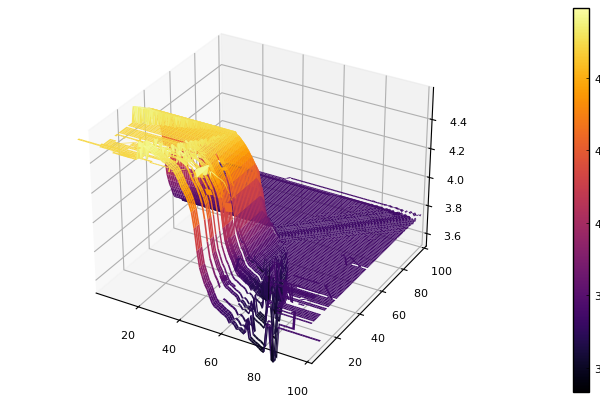

In [43]:
using Plots; pyplot()
x = 1:num_grid_x
y = 1:num_grid_x
f(x,y) = AA[x, y]
plot(x, y, f, st = :surface,)


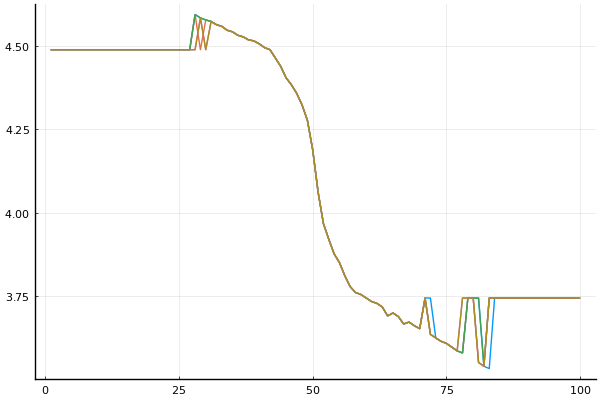

In [41]:
x = 1:num_grid_x
f(x) = AA[x, 1]
p = plot(x, f, legend = false)

for y in 2:5
    f(x) = AA[x, y]
    plot!(p, x, f, legend = false)
end

p

In [38]:
V_new[:, :, vec(LinearIndices((num_grid_x,num_grid_x))[:, 100])]

3×8×120 Array{Float64, 3}:
[:, :, 1] =
 3.74226  4.44499  3.71336  4.47747  3.91505  4.43743  3.96607  4.43541
 3.74514  3.74193  4.48383  4.41656  3.74436  3.74501  4.43667  4.43829
 4.4831   4.60268  4.58119  4.62989  5.05646  5.16885  5.046    5.17625

[:, :, 2] =
 3.74226  4.44499  3.71336  4.47747  3.91505  4.43743  3.96607  4.43541
 3.74514  3.74193  4.48383  4.41656  3.74436  3.74501  4.43667  4.43829
 4.4831   4.60268  4.58119  4.62989  5.05646  5.16885  5.046    5.17625

[:, :, 3] =
 3.74226  4.44499  3.71336  4.47747  3.91505  4.43743  3.96607  4.43541
 3.74514  3.74193  4.48383  4.41656  3.74436  3.74501  4.43667  4.43829
 4.4831   4.60268  4.58119  4.62989  5.05646  5.16885  5.046    5.17625

...

[:, :, 118] =
 3.74503  4.48366  3.73917  4.42871  3.74239  4.47763  3.80353  4.43817
 4.53049  4.42691  4.9756   4.91342  4.57302  4.63035  5.14028  5.22364
 3.68649  3.92406  4.03928  4.16142  4.4731   4.41595  4.43328  4.37963

[:, :, 119] =
 3.74121  4.38666  3.74598  4.43246 

In [26]:
V_new

3×8×14400 Array{Float64, 3}:
[:, :, 1] =
 4.47489  5.15825  4.54853  5.15475  4.52087  5.15482  4.72207  5.16803
 3.75511  3.74486  4.49179  4.42996  3.74146  3.78297  4.40018  4.44826
 3.74243  3.74493  3.745    3.78336  4.52273  4.43025  4.39994  4.43558

[:, :, 2] =
 4.47489  5.15825  4.54853  5.15475  4.76912  5.14366  4.72207  5.16803
 3.75511  3.74486  4.49179  4.42996  3.53048  3.79004  4.40018  4.44826
 3.74243  3.74493  3.745    3.78336  4.39772  4.43959  4.39994  4.43558

[:, :, 3] =
 4.47489  5.15416  4.54853  5.15475  4.76655  5.14011  4.72207  5.16803
 3.75511  3.75502  4.49179  4.42996  3.54052  3.80051  4.40018  4.44826
 3.74243  3.74251  3.745    3.78336  4.39514  4.43771  4.39994  4.43558

...

[:, :, 14398] =
 3.74026  4.35875  3.74197  4.45149  3.74047  4.45149  3.75756  4.43341
 3.94613  4.13103  4.47459  4.38919  4.34546  4.38919  4.62758  4.63928
 4.2974   4.36352  4.57194  4.68243  4.69658  4.68243  4.9787   4.99055

[:, :, 14399] =
 3.73168  4.51561  3.74197  4.

In [ ]:
# s_ind = 1;

# x_next_ind = ones(Int64, N - 1) * collect(1:num_grid_x)';
# x_low_ind_vec = zeros(N - 1, num_states);
# x_high_ind_vec = zeros(N - 1, num_states);

# for i in 2:N

#     Vi_aut_diff = abs.(util.(cons_array[i, s_ind, :], σ_vec[i]) .+ δ .* (V[i, :, :]' * R[s_ind, :]) .- Uaut_prod[s_ind][i])
#     @time x_low_ind_vec[i - 1, s_ind] = findmin(reduce(hcat, x_ind_prod[findall(Vi_aut_diff .== minimum(Vi_aut_diff))])[:, min(i - 1, 1)])[1];
    
#     V1_aut_diff = abs.(util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* (V[1, :, :]' * R[s_ind, :]) .- Uaut_prod[s_ind][1])
#     @time x_high_ind_vec[i - 1, s_ind] = findmax(reduce(hcat, x_ind_prod[findall(V1_aut_diff .== minimum(V1_aut_diff))])[:, min(i - 1, 1)])[1];;

# #     @time x_low_ind_vec[i - 1, s_ind] = x_ind_prod[
# #         findmin(abs.(util.(cons_array[i, s_ind, :], σ_vec[i]) .+ δ .* (V[i, :, :]' * R[s_ind, :]) .- Uaut_prod[s_ind][i]))[2]
# #     ][i - 1];
# #     @time x_high_ind_vec[i - 1, s_ind] = x_ind_prod[
# #         findmin(abs.(util.(cons_array[1, s_ind, :], σ_vec[1]) .+ δ .* (V[1, :, :]' * R[s_ind, :]) .- Uaut_prod[s_ind][1]))[2]
# #     ][i - 1];
        
#     x_next_ind[i - 1, x_next_ind[i - 1, :] .<= x_low_ind_vec[i - 1, s_ind]] .= x_low_ind_vec[i - 1, s_ind];
#     x_next_ind[i - 1, x_next_ind[i - 1, :] .>= x_high_ind_vec[i - 1, s_ind]] .= x_high_ind_vec[i - 1, s_ind];    
# end




In [ ]:
# V1 = V1_full;
# V2 = V2_full;
# V1_new = zeros(num_states, num_grid_x);
# V2_new = zeros(num_states, num_grid_x);

In [ ]:
# diff = 1.0
# iter = 1
# delta_diff = 1.0
# @time while (diff > 1e-6) & (iter < 1000) & (delta_diff != 0.0)

#     for s_ind in 1:num_states
#         x_low_ind  = findmin(abs.(util.(cons1[s_ind, :], σ₁) .+ δ .* (V1' * R[s_ind, :]) .- Uaut_1[s_ind]))[2];
#         x_high_ind = findmin(abs.(util.(cons2[s_ind, :], σ₂) .+ δ .* (V2' * R[s_ind, :]) .- Uaut_2[s_ind]))[2];

#         x_next_ind = collect(1:num_grid_x);
#         x_next_ind[x_next_ind .<= x_low_ind] .= x_low_ind;
#         x_next_ind[x_next_ind .>= x_high_ind] .= x_high_ind;

#         V1_new[s_ind, :] = util.(cons1[s_ind, x_next_ind], σ₁) .+ δ .* (V1[:, x_next_ind]' * R[s_ind, :]);
#         V2_new[s_ind, :] = util.(cons2[s_ind, x_next_ind], σ₂) .+ δ .* (V2[:, x_next_ind]' * R[s_ind, :]);
#     end;

#     diff_new = maximum(abs.(V1 .- V1_new) + abs.(V2 .- V2_new));
#     delta_diff = diff - diff_new;
#     diff = diff_new

#     V1 = V1_new[:, :];
#     V2 = V2_new[:, :];
    
#     iter += 1
# end

In [ ]:
# s_ind = 1;
# x_ind = 1;

# model = Model(Ipopt.Optimizer);
# set_silent(model)

# @variable(model, c[i = 1:2] >= 1e-6);
# @variable(model, x[i = 1:num_states] >= 0.0);

# register(model, :util_1, 1, x -> util(x, σ₁), x -> util_prime(x, σ₁); autodiff = true)
# register(model, :util_2, 1, x -> util(x, σ₂), x -> util_prime(x, σ₂); autodiff = true)

# register(
#     model,
#     :V1_colloc,
#     1,
#     x -> R[s_ind, :]' * [funeval(V1_collocation[i][1], basis, [x])[1][1, 1] for i in 1:num_states];
#     autodiff = true
#     );
# register(
#     model,
#     :V1_colloc,
#     1,
#     x -> R[s_ind, :]' * [funeval(V2_collocation[i][1], basis, [x])[1][1, 1] for i in 1:num_states];
#     autodiff = true
#     );

# @NLobjective(
#     model, 
#     Max, 
#     util_1(c[1]) + δ * exp_V1_colloc
# );

# @NLconstraint(
#     model, 
#     PC1,
#     util_1(c[1]) + δ * exp_V1_colloc >= Uaut_1[s_ind]
# );
# @NLconstraint(
#     model, 
#     PC2,
#     util_2(c[2]) + δ * exp_V2_colloc >= Uaut_2[s_ind]
# );

# @NLconstraint(
#     model, 
#     sum(c[i] for i in 1:2) <= inc_ag[s_ind]
# );

# @time optimize!(model)

# print(value.(c), "\n")
# @show value.(x)



In [ ]:
# s_ind = 1;
# x_ind = 1;

# basis = fundefn(:spli, num_grid_x, xmin, xmax);
# V1_collocation = [funfitxy(basis, funnode(basis)[1], V1[i, :]) for i in 1:num_states];
# V2_collocation = [funfitxy(basis, funnode(basis)[1], V2[i, :]) for i in 1:num_states];

# x_sol = zeros(num_states, num_grid_x);

# @time for s_ind in 1:num_states, x_ind in 1:num_grid_x
#     model = Model(Ipopt.Optimizer);
#     set_silent(model)

#     @variable(model, c[i = 1:2] >= 1e-10);
#     @variable(model, x >= 0.0);

#     register(model, :util_1, 1, x -> util(x, σ₁), x -> util_prime(x, σ₁); autodiff = true)
#     register(model, :util_2, 1, x -> util(x, σ₂), x -> util_prime(x, σ₂); autodiff = true)

#     register(
#         model,
#         :V1_colloc,
#         1,
#         x -> R[s_ind, :]' * collect([funeval(V1_collocation[i][1], basis, [x])[1][1,1] for i in 1:num_states]);
#         autodiff = true
#         );
#     register(
#         model,
#         :V2_colloc,
#         1,
#         x -> R[s_ind, :]' * collect([funeval(V2_collocation[i][1], basis, [x])[1][1,1] for i in 1:num_states]);
#         autodiff = true
#         );

#     @NLobjective(
#         model, 
#         Max, 
#         util_1(c[1]) + δ * V1_colloc(x)
#     );

#     @NLconstraint(
#         model, 
#         util_1(c[1]) + δ * V1_colloc(x) >= Uaut_1[s_ind]
#     );
#     @NLconstraint(
#         model, 
#         util_2(c[2]) + δ * V2_colloc(x) >= Uaut_2[s_ind]
#     );

#     @NLconstraint(
#         model, 
#         sum(c[i] for i in 1:2) <= inc_ag[s_ind]
#     );

#     optimize!(model)
    
#     print(value.(c), "\n")
#     x_sol[s_ind, x_ind] = value(x)
# end